In [720]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from babel.numbers import get_currency_symbol
import humanize

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)

## Initialization

In [721]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [722]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [723]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : MUNDYS.
Selected year : 2022.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [724]:
def compute_company_available_reports(
        df: pd.DataFrame=df, company: str=company) -> dict:
    
    available_years = df.loc[df['mnc'] == company, 'year'].unique()
    n_reports = len(available_years)

    # Convert type of items from 'int' to 'str' in available years list
    years_string_list = [str(year) for year in available_years]
    
    if len(years_string_list) == 1:
        years_string = years_string_list[0]
    elif len(years_string_list) > 1:
        years_string = ', '.join(years_string_list[:-1])
        years_string += ' and ' + years_string_list[-1]

    data = {
        'Company': company,
        'Reports': n_reports,
        'Fiscal year(s) available': years_string
    }

    return data


data =compute_company_available_reports()
pd.DataFrame.from_dict(data=data, orient='index').style.hide(axis='columns')

Company,MUNDYS
Reports,1
Fiscal year(s) available,2022


## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [725]:
def compute_company_key_financials_kpis(
        df: pd.DataFrame=df, company: str=company, year: int=None) -> dict:
    
    # List financial kpis
    kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
                 'profit_before_tax', 'tax_paid', 'employees']
    
    years = df.loc[df['mnc'] == company, 'year'].unique()
    currency = df['currency'].unique()[0]
    currency_symbol = get_currency_symbol(currency, locale='en_US')

    if not year or year not in years:
        df = (df.loc[df['mnc'] == company]
            .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
            .sum()
        )
    else:
        df = (df.loc[(df['mnc'] == company) & (df['year'] == year)]
              .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
              .sum())

    df = df.set_index('year')

    for column in df.columns:
        if column not in ['employees', 'upe_name']:
            df[column] = df[column].apply(
                lambda x: humanize.intword(x) if isinstance(x, (int, float)) else x)
            df[column] = currency_symbol + ' ' + df[column]
        elif column == 'employees':
            df[column] = df[column].astype(int)

    df = df.rename(columns={'upe_name': 'headquarter'})
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()

    data = df.to_dict(orient='index')

    return data

In [726]:
data = compute_company_key_financials_kpis()
pd.DataFrame.from_dict(data)

,2022
Headquarter,Italy
Total revenues,€ 14.6 billion
Unrelated revenues,€ 14.4 billion
Related revenues,€ 233.2 million
Profit before tax,€ 3.5 billion
Tax paid,€ 553.1 million
Employees,23374


## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

In [727]:
def compute_top_jurisdictions_revenue(
        df: pd.DataFrame=df, company: str=company, year:int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df[:9].copy()

    others = df[9:]['total_revenues'].sum()
    top.loc[9] = ['Others', others]

    top['total_revenues_%'] = top['total_revenues'] / top['total_revenues'].sum() * 100

    top = top.sort_values(by='total_revenues_%').reset_index(drop=True)

    data = top.to_dict()
    
    return data

In [728]:
pd.DataFrame(compute_top_jurisdictions_revenue())

,jur_name,total_revenues,total_revenues_%
0,United Kingdom,1.687000e+08,1.153189
1,Puerto Rico,1.875000e+08,1.281701
2,Argentina,4.022000e+08,2.749334
3,Others,6.495000e+08,4.439811
4,Mexico,7.461000e+08,5.100144
5,Spain,7.820000e+08,5.345547
6,Chile,1.540400e+09,10.529770
7,Brazil,1.571800e+09,10.744412
8,France,2.409600e+09,16.471392
9,Italy,6.171200e+09,42.184702


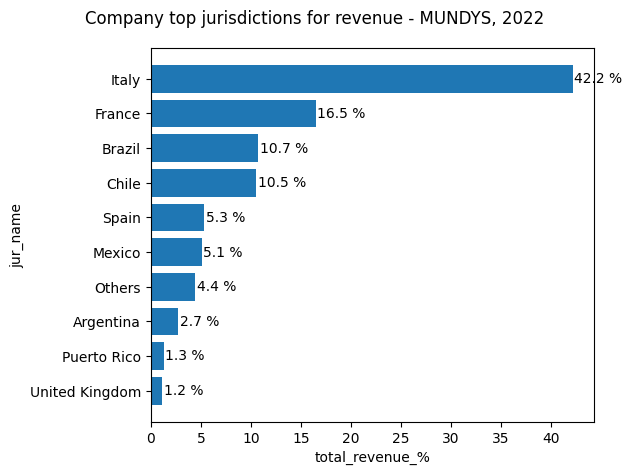

In [729]:
def plot_jurisdictions_top_revenue():

    top = pd.DataFrame(compute_top_jurisdictions_revenue())

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['total_revenues_%'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('total_revenue_%')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue()

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [730]:
def compute_pretax_profit_and_employees_rank(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    df = df.fillna(0)
    df = df.sort_values(by='profit_before_tax').reset_index(drop=True)

    df['profit_before_tax_%'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['employees_%'] = df['employees'] / df['employees'].sum() * 100

    data = df.to_dict()

    return data

In [731]:
pd.DataFrame(compute_pretax_profit_and_employees_rank())

,jur_name,profit_before_tax,employees,profit_before_tax_%,employees_%
0,Croatia,2.000000e+05,55.0,0.003807,0.358353
1,Hungary,5.000000e+05,36.0,0.009519,0.234558
2,China,8.000000e+05,31.0,0.015230,0.201981
3,Czechia,1.600000e+06,104.0,0.030460,0.677613
4,United Kingdom,3.600000e+06,1246.0,0.068535,8.118322
5,Austria,4.800000e+06,138.0,0.091380,0.899140
6,Netherlands,6.500000e+06,165.0,0.123744,1.075059
7,India,1.670000e+07,53.0,0.317926,0.345322
8,Argentina,2.280000e+07,1801.0,0.434054,11.734428
9,Germany,2.520000e+07,1064.0,0.479744,6.932499


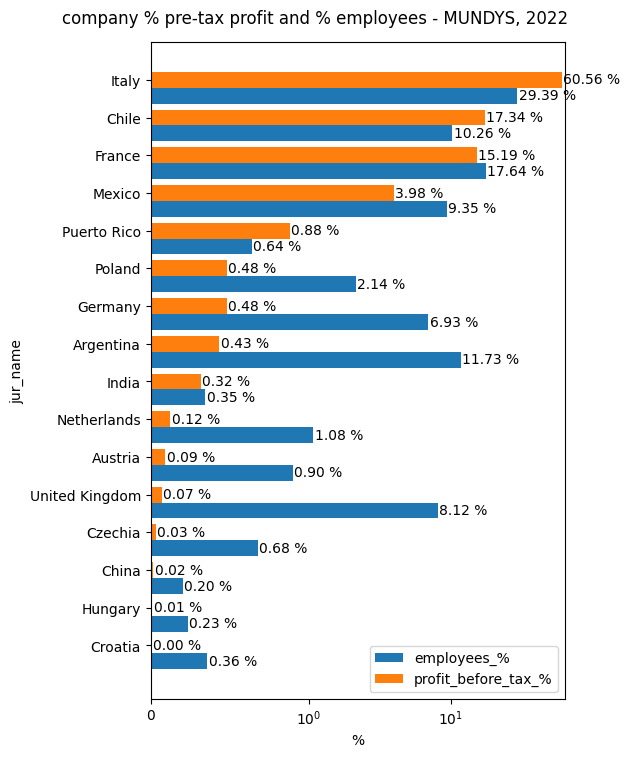

In [732]:
def plot_pretax_profit_and_employees_rank():

    rank = pd.DataFrame(compute_pretax_profit_and_employees_rank())

    jurisdictions = rank['jur_name'].values
    bar_width = 0.42
    bar_offsets = [-bar_width, 0, bar_width]

    fig_height = max(4.8, (0.48*len(jurisdictions)))
    fig, ax = plt.subplots(figsize=(6.4, fig_height))

    for i, (column, values) in enumerate(rank[['employees_%', 'profit_before_tax_%']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.2f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.set_xscale('symlog', linthresh=1)
    ax.legend(loc='lower right')
       
    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank()

## #18 - breakdown of revenue between related party and unrelated party in TH vs domestic vs non TH

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal barchart % of revenue from related-party revenue, and % revenue from unrelated party, show value for domestic (hq country) vs tax havens vs. non havens|get total revenue in TH, in domestic country, in non TH then show the % coming from unrelated party revenue and related party revenue (sum of both should equal total revenue)||`company explo` need a filter by company|what if sum or unrelated party revenue  and related party revenue does not equal to total revenue ? safeguard ?|

In [753]:
def compute_related_and_unrelated_revenues_breakdown(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year)]

    revenues_columns = ['unrelated_revenues', 'related_revenues', 'total_revenues']

    computed_df = pd.DataFrame()
    computed_df['th_revenues'] = (
        df.loc[df['jur_tax_haven'] == True, revenues_columns].sum())
    computed_df['domestic_revenues'] = (
        df.loc[df['jur_code'] == df['upe_code'], revenues_columns].sum())
    computed_df['non_th_revenues'] = (
        df.loc[df['jur_tax_haven'] == False, revenues_columns].sum())
    
    computed_df = computed_df.T

    # computed_df['unrelated_revenues_%'] = computed_df['unrelated_revenues'] / computed_df['total_revenues'] * 100
    # computed_df['related_revenues_%'] = computed_df['related_revenues'] / computed_df['total_revenues'] * 100

    return computed_df

compute_related_and_unrelated_revenues_breakdown()

,unrelated_revenues,related_revenues,total_revenues
th_revenues,2.133000e+08,79000000.0,2.923000e+08
domestic_revenues,6.163200e+09,8000000.0,6.171200e+09
non_th_revenues,1.418250e+10,154200000.0,1.433670e+10


In [754]:
z = compute_related_and_unrelated_revenues_breakdown()[['unrelated_revenues', 'related_revenues']]
z = z.div(z.sum(axis=1), axis=0) * 100
z

,unrelated_revenues,related_revenues
th_revenues,72.972973,27.027027
domestic_revenues,99.870366,0.129634
non_th_revenues,98.924439,1.075561


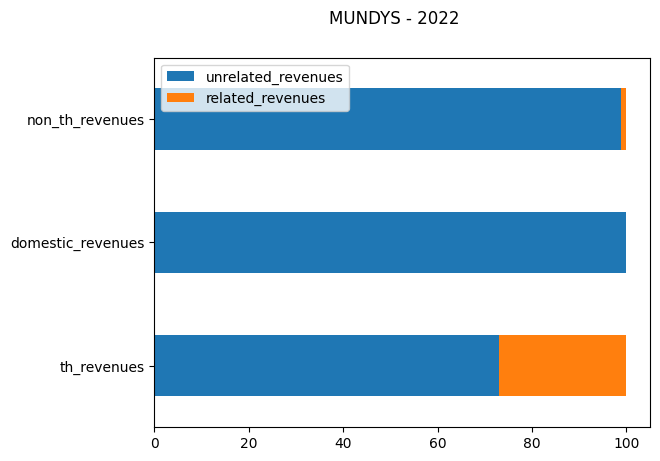

In [756]:
fig, ax = plt.subplots()

test = compute_related_and_unrelated_revenues_breakdown()[['unrelated_revenues', 'related_revenues']]
z.plot(kind='barh', stacked=True, ax=ax)

fig.suptitle(f'{company} - {year}')
plt.show()